In [3]:
import numpy as np 
import pandas as pd

from os.path import join
import time
import random

from sklearn.metrics import mean_squared_error

from matplotlib import pylab as plt
%matplotlib inline

### Загрузка данных

In [4]:
path_data = './data'
train = pd.read_csv(join(path_data, 'train.txt'), names=['user', 'item', 'mark'], header=None, sep='\t')
test = pd.read_csv(join(path_data, 'test.txt'), names=['user', 'item'], header=None, sep='\t')

In [5]:
train.head()

,user,item,mark
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
test.head()

,user,item
0,1,20
1,1,33
2,1,61
3,1,117
4,1,155


### Парсинг данных

In [7]:
# -- Составляем основную матрицу user-item
user_item_table = train.pivot_table(columns='item', index='user', values='mark').fillna(0)

In [8]:
user_item_table.head(10)

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
itemID_columnID = {}
for i, a in enumerate(user_item_table.columns):
    itemID_columnID[a] = i

In [10]:
# -- Подсчет среднего для оценок (не учитывая нули)
def mean_known(arr):
    count_zeros = np.count_nonzero(arr, axis=1)
    count_zeros[count_zeros == 0.0] = 1.0
    return (arr.sum(axis=1)).astype(float) / count_zeros

In [11]:
# -- Заполнение нулей средним значением оценки пользователя
def fillzero2mean(arr):
    mean_user = mean_known(arr)
    mean_item = mean_known(arr.T)
    for i in xrange(len(mean_user)):
        for j in xrange(len(mean_item)):
            if arr[i, j] == 0:
                arr[i, j] = np.mean([mean_user[i], mean_item[j]])
    
    return arr

In [12]:
user_item = user_item_table.values

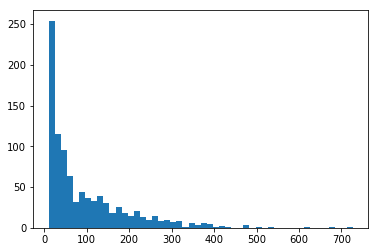

96.0445387063


In [13]:
count_mark = np.asarray([np.count_nonzero(u) for u in user_item])
plt.hist(count_mark, bins=50)
plt.show()

print count_mark.mean()

In [14]:
def count_log(arr):
    for row in xrange(len(arr)):
        arr[row] = [np.log(np.count_nonzero(arr[row]) + 1)] * len(arr[row])
    return np.array(arr)

In [15]:
def count_log(arr):
    for row in xrange(len(arr)):
        arr[row] = np.array([(np.count_nonzero(arr[row]) + 1)] * len(arr[row])) / len(arr[row])
    return np.array(arr)

### Cross-validation

In [16]:
def train_test_split(user_item, test_size=0.6):
    trainCV = user_item.copy()
    non_zero = []
    for user in xrange(user_item.shape[0]):
        for item in xrange(user_item.shape[1]):
            if user_item[user, item] > 0:
                non_zero.append((user, item))
    
    random.shuffle(non_zero)
    test = non_zero[: int(len(non_zero) * test_size)]
    train = non_zero[int(len(non_zero) * test_size) :]
    
    for cell in test:
        trainCV[cell[0], cell[1]] = 0.0
        
    return trainCV, test, train

In [17]:
trainCV, testCV, train_pairs = train_test_split(user_item, test_size = 0.1)
trainCV_fillna = fillzero2mean(trainCV.copy())

In [18]:
trainCV_count_log = count_log(trainCV.copy())

### Accuracy

In [19]:
def MSE(test, predict, train):
    result = 0
    for cell in test:
        result += (predict[cell[0], cell[1]] - train[cell[0], cell[1]]) ** 2
    
    return result / len(test)

### Графики

In [20]:
def plot_MSE(setsMSE):
    plt.figure(figsize=(10,10))
    
    for i, (MSE_train, MSE_test) in enumerate(setsMSE):
        plt.plot(range(len(MSE_train)), MSE_train, label='Train ' + str(i), color='b')
        plt.plot(range(len(MSE_test)), MSE_test, label='Test ' + str(i), color='r')
        
    plt.legend()
    return plt

### I-ALS

In [87]:
myIALS = IALS(n_iterations=15, n_features=100, penalty=0.3, alpha=40) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

1291.13039528
___________________
Step: 0
0.285347688963
MSE All: 0.135414
MSE Train: 0.145999
MSE Test: 1.098503
Time: 74.974 sec
1243.76914935
___________________
Step: 1
0.220181275679
MSE All: 0.087147
MSE Train: 0.049976
MSE Test: 1.034526
Time: 71.276 sec
1210.72754086
___________________
Step: 2
0.183165718276
MSE All: 0.077869
MSE Train: 0.035532
MSE Test: 1.011064
Time: 78.551 sec
1193.10080004
___________________
Step: 3
0.171735497216
MSE All: 0.073936
MSE Train: 0.030812
MSE Test: 0.996863
Time: 78.738 sec


KeyboardInterrupt: 

In [118]:
myIALS2 = IALS(n_iterations=15, n_features=2, penalty=2.0, alpha=40) 
myIALS2.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
1.54809556911
MSE All: 2.934154
MSE Train: 4.047003
MSE Test: 4.051590
Time: 30.968 sec
___________________
Step: 1
1.56563118504
MSE All: 2.896967
MSE Train: 4.046263
MSE Test: 4.049588
Time: 30.530 sec
___________________
Step: 2
1.56263162183
MSE All: 2.892431
MSE Train: 4.048238
MSE Test: 4.051620
Time: 30.913 sec
___________________
Step: 3
1.5620110562
MSE All: 2.891627
MSE Train: 4.048623
MSE Test: 4.052020
Time: 31.560 sec
___________________
Step: 4
1.56189627708
MSE All: 2.891484
MSE Train: 4.048692
MSE Test: 4.052092
Time: 30.899 sec
___________________
Step: 5
1.56187554717
MSE All: 2.891458
MSE Train: 4.048705
MSE Test: 4.052105
Time: 31.719 sec
___________________
Step: 6
1.56187185086
MSE All: 2.891454
MSE Train: 4.048707
MSE Test: 4.052107
Time: 30.916 sec
___________________
Step: 7
1.56187119666
MSE All: 2.891453
MSE Train: 4.048707
MSE Test: 4.052108
Time: 31.879 sec
___________________
Step: 8
1.56187108137
MSE All: 2.891453
MSE Train: 4.

<__main__.IALS instance at 0x11ca6d050>

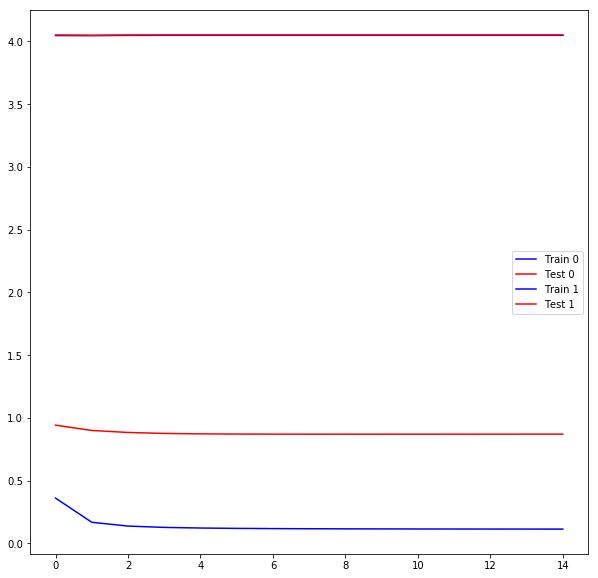

In [119]:
plot_MSE([(myIALS.MSE_train, myIALS.MSE_test), (myIALS2.MSE_train, myIALS2.MSE_test)]).show()

In [ ]:
class IALS():
    def __init__(self, n_iterations=20, n_features=100, penalty=0.001, alpha=40):
        self.n_iterations = n_iterations
        self.n_features = n_features
        self.penalty = penalty
        self.alpha = alpha
        
    def fit(self, data_table, data_table_fillna, data_table_count_log, original, add=False, new_alpha=None, new_n_iteration=None, new_penalty=None):
        if not add:
            self.X = []
            self.Y = []
        
#             self.MSE_train = []
#             self.MSE_test = []

            X = np.random.rand(data_table.shape[0], self.n_features)  # -- m x f
            Y = np.random.rand(data_table.shape[1], self.n_features)  # -- n x f
        else:
            if new_alpha:
                self.alpha = new_alpha
            if new_n_iteration:
                self.n_iterations = new_n_iteration
            if new_penalty:
                self.penalty = new_penalty
                
            X = self.X[-1].copy()
            Y = self.Y[-1].copy()
            
        C = 1.0 + self.alpha * (data_table > 0).astype(float) 
#         + data_table_count_log)
#         self.alpha * (data_table > 0).astype(float) \
#          + 
#                  +  * (data_table > 0).astype(float)              # -- weights Cu 
                   
#         C = 1 + self.alpha * user_item
        C_I = C - np.ones(C.shape) # -- Cu - I array
        lambdaI = self.penalty  * np.eye(self.n_features)
        
        last_time = time.time()
        for stage in xrange(self.n_iterations):
            
            # -- X^T Ci X = X^T X + X^T (Ci - I) X
            # -- X^T X - independent on user
            
            # -- Y^T Cu Y = Y^T Y + Y^T (Cu - I) Y
            # -- Y^T Y - independent on user
            
            YTY = np.dot(Y.T, Y)
            
#             tmpX = np.zeros(X.shape)
#             tmpY = np.zeros(Y.shape)
            
            for user in xrange(data_table.shape[0]):
                tmp = YTY.copy()
                tmp = tmp + np.dot(np.dot(Y.T, np.diag(C_I[user])), Y)  # -- Y^T (Cu - I) Y
#                 tmp = np.dot(np.dot(Y.T, np.diag(C[user])), Y)
                tmp = tmp + lambdaI
#                 tmp = tmp + self.penalty * tmp.mean() * np.eye(self.n_features)
                tmp = np.linalg.inv(tmp)
                tmp = np.dot(np.dot(tmp, Y.T), np.diag(C[user]))
                tmp = np.dot(tmp, data_table_fillna[user])
                X[user] = tmp
                
            XTX = np.dot(X.T, X)
            
            for item in xrange(data_table.shape[1]):
                tmp = XTX.copy()
                tmp = tmp + np.dot(np.dot(X.T, np.diag(C_I[:, item])), X)  # -- X^T (Cu - I) X
#                 tmp = np.dot(np.dot(X.T, np.diag(C[:, item])), X)
                tmp = tmp + lambdaI
#                 tmp = tmp + self.penalty * tmp.mean() * np.eye(self.n_features)
                tmp = np.linalg.inv(tmp)
                tmp = np.dot(np.dot(tmp, X.T), np.diag(C[:, item]))
                tmp = np.dot(tmp, data_table_fillna[:, item])
                Y[item] = tmp
                
#             X = tmpX.copy()
#             Y = tmpY.copy()
            print '___________________'
            print "Step: %d" %stage
            predicted = np.dot(X, Y.T)
            print "MSE All: %f" %mean_squared_error(predicted, data_table_fillna)
            print "MSE Train: %f" %MSE(train_pairs, predicted, original)    
            print "MSE Test: %f" %MSE(testCV, predicted, original)
            print "Time: {:.3f} sec".format(time.time() - last_time)
            last_time = time.time()
            
        self.X.append(X.copy())
        self.Y.append(Y.copy())
        
        return self
    
    def predict(self):
        return np.dot(self.X[-1], self.Y[-1].T)
        
        

In [122]:
myIALS = IALS(n_iterations=10, n_features=100, penalty=300.0, alpha=40) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
0.226440817513
MSE All: 0.939989
MSE Train: 0.622290
MSE Test: 1.132929
Time: 71.338 sec
___________________
Step: 1
0.376424654632
MSE All: 0.465275
MSE Train: 0.360987
MSE Test: 1.009093
Time: 69.817 sec
___________________
Step: 2
0.401934744717
MSE All: 0.300036
MSE Train: 0.300983
MSE Test: 0.980687
Time: 69.963 sec
___________________
Step: 3
0.395838261346
MSE All: 0.218883
MSE Train: 0.270375
MSE Test: 0.946849
Time: 69.581 sec
___________________
Step: 4
0.392912722645
MSE All: 0.177095
MSE Train: 0.251932
MSE Test: 0.919257
Time: 69.719 sec
___________________
Step: 5
0.395004513266
MSE All: 0.152830
MSE Train: 0.240835
MSE Test: 0.900637
Time: 69.605 sec
___________________
Step: 6
0.397402151265
MSE All: 0.137070
MSE Train: 0.233946
MSE Test: 0.888322
Time: 69.918 sec
___________________
Step: 7
0.398212159729
MSE All: 0.125985
MSE Train: 0.229437
MSE Test: 0.879981
Time: 69.702 sec
___________________
Step: 8
0.397339889149
MSE All: 0.117751
MSE

<__main__.IALS instance at 0x11ccb2bd8>

In [123]:
myIALS2 = IALS(n_iterations=10, n_features=100, penalty=350.0, alpha=40) 
myIALS2.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
0.084623021203
MSE All: 1.097027
MSE Train: 0.710357
MSE Test: 1.163991
Time: 68.190 sec
___________________
Step: 1
-0.0852750320195
MSE All: 0.536258
MSE Train: 0.437142
MSE Test: 1.016593
Time: 67.618 sec
___________________
Step: 2
-0.109417022529
MSE All: 0.344631
MSE Train: 0.365083
MSE Test: 0.976735
Time: 67.961 sec
___________________
Step: 3
-0.0989742949583
MSE All: 0.249741
MSE Train: 0.329765
MSE Test: 0.938598
Time: 70.721 sec
___________________
Step: 4
-0.0925763963881
MSE All: 0.200965
MSE Train: 0.308988
MSE Test: 0.909050
Time: 70.204 sec
___________________
Step: 5
-0.0929268156021
MSE All: 0.172772
MSE Train: 0.296609
MSE Test: 0.889467
Time: 69.776 sec
___________________
Step: 6
-0.0959980846632
MSE All: 0.154561
MSE Train: 0.288968
MSE Test: 0.876831
Time: 66.963 sec
___________________
Step: 7
-0.0988326313084
MSE All: 0.141824
MSE Train: 0.283990
MSE Test: 0.868524
Time: 67.742 sec
___________________
Step: 8
-0.100093471635
MSE All

<__main__.IALS instance at 0x11c612998>

In [124]:
myIALS3 = IALS(n_iterations=10, n_features=100, penalty=400.0, alpha=40) 
myIALS3.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
-0.0161840787083
MSE All: 1.263927
MSE Train: 0.797372
MSE Test: 1.211129
Time: 67.973 sec
___________________
Step: 1
0.0488817189212
MSE All: 0.617272
MSE Train: 0.514139
MSE Test: 1.024633
Time: 72.428 sec
___________________
Step: 2
0.103118176442
MSE All: 0.391011
MSE Train: 0.433629
MSE Test: 0.973158
Time: 68.148 sec
___________________
Step: 3
0.141147813418
MSE All: 0.279632
MSE Train: 0.392021
MSE Test: 0.927998
Time: 68.030 sec
___________________
Step: 4
0.163561368883
MSE All: 0.223965
MSE Train: 0.367979
MSE Test: 0.896476
Time: 67.808 sec
___________________
Step: 5
0.177735961749
MSE All: 0.192382
MSE Train: 0.354281
MSE Test: 0.877572
Time: 68.042 sec
___________________
Step: 6
0.187593370521
MSE All: 0.172168
MSE Train: 0.346092
MSE Test: 0.866229
Time: 67.658 sec
___________________
Step: 7
0.195184948428
MSE All: 0.158109
MSE Train: 0.340855
MSE Test: 0.859116
Time: 67.763 sec
___________________
Step: 8
0.201551404178
MSE All: 0.147779


<__main__.IALS instance at 0x128dfcb90>

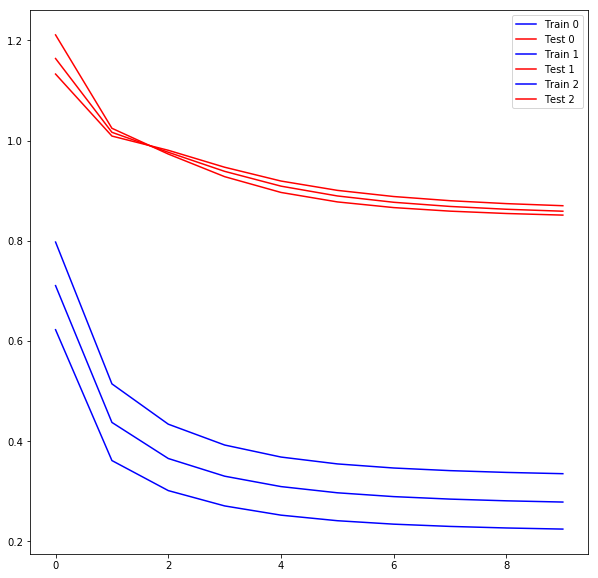

In [125]:
plot_MSE([(myIALS.MSE_train, myIALS.MSE_test), (myIALS2.MSE_train, myIALS2.MSE_test), (myIALS3.MSE_train, myIALS3.MSE_test)]).show()

In [126]:
myIALS = IALS(n_iterations=10, n_features=100, penalty=300.0, alpha=20) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
0.348485679971
MSE All: 1.078051
MSE Train: 1.003213
MSE Test: 1.250148
Time: 67.574 sec
___________________
Step: 1
0.450842063597
MSE All: 0.484041
MSE Train: 0.761114
MSE Test: 1.024061
Time: 67.730 sec
___________________
Step: 2
0.46286595707
MSE All: 0.303021
MSE Train: 0.665647
MSE Test: 0.951902
Time: 67.601 sec
___________________
Step: 3
0.473929557852
MSE All: 0.218564
MSE Train: 0.614682
MSE Test: 0.907702
Time: 67.690 sec
___________________
Step: 4
0.485968992113
MSE All: 0.175526
MSE Train: 0.587292
MSE Test: 0.882698
Time: 67.597 sec
___________________
Step: 5
0.49652237806
MSE All: 0.150639
MSE Train: 0.572285
MSE Test: 0.869010
Time: 68.048 sec
___________________
Step: 6
0.505218097147
MSE All: 0.134598
MSE Train: 0.563462
MSE Test: 0.861097
Time: 70.724 sec
___________________
Step: 7
0.512429165698
MSE All: 0.123463
MSE Train: 0.557870
MSE Test: 0.856193
Time: 73.961 sec
___________________
Step: 8
0.518530184997
MSE All: 0.115342
MSE T

<__main__.IALS instance at 0x11c81b830>

In [127]:
myIALS2 = IALS(n_iterations=10, n_features=100, penalty=300.0, alpha=10) 
myIALS2.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
0.125443856785
MSE All: 1.274378
MSE Train: 1.409115
MSE Test: 1.506976
Time: 68.832 sec
___________________
Step: 1
0.163884977018
MSE All: 0.491852
MSE Train: 1.061171
MSE Test: 1.124116
Time: 69.412 sec
___________________
Step: 2
0.17849409997
MSE All: 0.306188
MSE Train: 0.945894
MSE Test: 1.009655
Time: 70.277 sec
___________________
Step: 3
0.177983782053
MSE All: 0.225518
MSE Train: 0.897535
MSE Test: 0.963023
Time: 70.861 sec
___________________
Step: 4
0.174988075069
MSE All: 0.181944
MSE Train: 0.872042
MSE Test: 0.939096
Time: 68.076 sec
___________________
Step: 5
0.172391383252
MSE All: 0.155673
MSE Train: 0.856941
MSE Test: 0.925269
Time: 69.069 sec
___________________
Step: 6
0.170556129987
MSE All: 0.138659
MSE Train: 0.847383
MSE Test: 0.916693
Time: 69.104 sec
___________________
Step: 7
0.169322439064
MSE All: 0.127063
MSE Train: 0.841052
MSE Test: 0.911113
Time: 70.827 sec
___________________
Step: 8
0.168504956725
MSE All: 0.118850
MSE 

<__main__.IALS instance at 0x11cd41878>

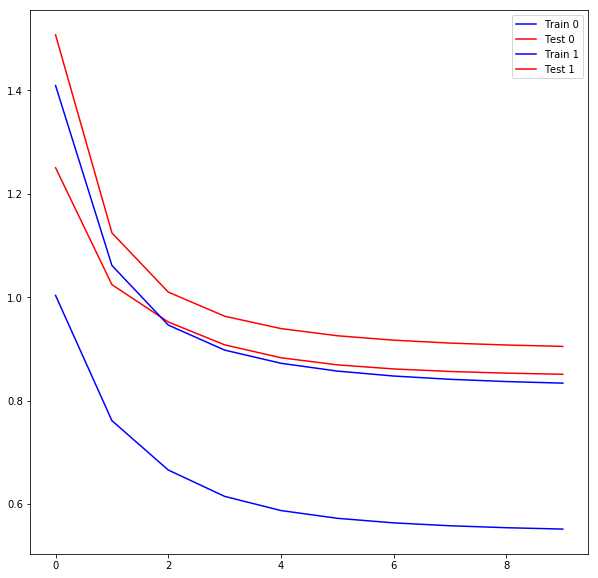

In [128]:
plot_MSE([(myIALS.MSE_train, myIALS.MSE_test), (myIALS2.MSE_train, myIALS2.MSE_test)]).show()

In [129]:
myIALS = IALS(n_iterations=10, n_features=150, penalty=350.0, alpha=40) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
-0.0820487384737
MSE All: 1.649174
MSE Train: 0.765630
MSE Test: 1.350897
Time: 91.073 sec
___________________
Step: 1
0.0258442849087
MSE All: 0.555035
MSE Train: 0.419817
MSE Test: 1.043856
Time: 91.645 sec
___________________
Step: 2
0.0908788764889
MSE All: 0.312974
MSE Train: 0.339245
MSE Test: 0.964481
Time: 91.940 sec
___________________
Step: 3
0.101251313018
MSE All: 0.229085
MSE Train: 0.308605
MSE Test: 0.920827
Time: 100.443 sec
___________________
Step: 4
0.0958600927546
MSE All: 0.188348
MSE Train: 0.293110
MSE Test: 0.895238
Time: 101.461 sec
___________________
Step: 5
0.0867342131122
MSE All: 0.164241
MSE Train: 0.284214
MSE Test: 0.879268
Time: 104.275 sec
___________________
Step: 6
0.0779480476152
MSE All: 0.148273
MSE Train: 0.278763
MSE Test: 0.868970
Time: 92.170 sec
___________________
Step: 7
0.0705459621517
MSE All: 0.136901
MSE Train: 0.275233
MSE Test: 0.862143
Time: 93.308 sec
___________________
Step: 8
0.0646143394867
MSE All: 

<__main__.IALS instance at 0x11c83a950>

In [130]:
myIALS2 = IALS(n_iterations=10, n_features=70, penalty=350.0, alpha=40) 
myIALS2.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
0.155696400302
MSE All: 0.722936
MSE Train: 0.699102
MSE Test: 1.057543
Time: 58.784 sec
___________________
Step: 1
0.16184232323
MSE All: 0.427901
MSE Train: 0.447592
MSE Test: 0.970185
Time: 58.937 sec
___________________
Step: 2
0.168664750644
MSE All: 0.309785
MSE Train: 0.381460
MSE Test: 0.952502
Time: 59.793 sec
___________________
Step: 3
0.136948643524
MSE All: 0.239396
MSE Train: 0.350836
MSE Test: 0.930685
Time: 57.560 sec
___________________
Step: 4
0.108079907146
MSE All: 0.198056
MSE Train: 0.331879
MSE Test: 0.909397
Time: 58.164 sec
___________________
Step: 5
0.0873481565201
MSE All: 0.172645
MSE Train: 0.319871
MSE Test: 0.893560
Time: 58.452 sec
___________________
Step: 6
0.0713135915266
MSE All: 0.155795
MSE Train: 0.312141
MSE Test: 0.882833
Time: 65.462 sec
___________________
Step: 7
0.0571243217022
MSE All: 0.143859
MSE Train: 0.306963
MSE Test: 0.875689
Time: 66.153 sec
___________________
Step: 8
0.0432243911144
MSE All: 0.134981


<__main__.IALS instance at 0x11cd84638>

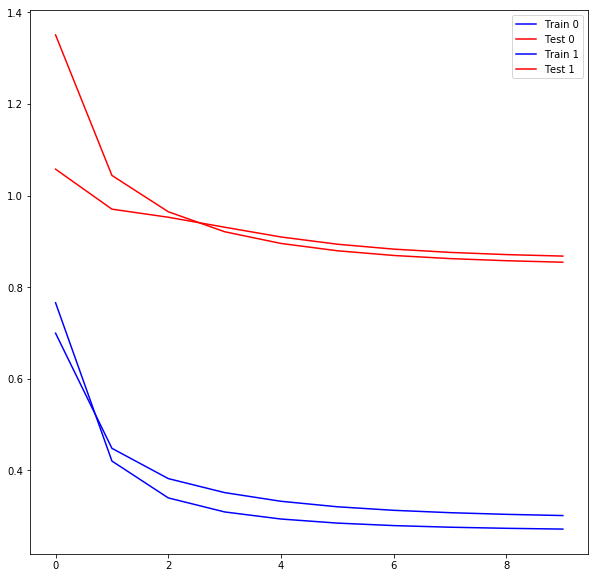

In [131]:
plot_MSE([(myIALS.MSE_train, myIALS.MSE_test), (myIALS2.MSE_train, myIALS2.MSE_test)]).show()

In [29]:
# Больше 5
myIALS = IALS(n_iterations=30, n_features=150, penalty=400.0, alpha=40) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), user_item.copy())

___________________
Step: 0
MSE All: 1.686152
MSE Train: 0.593390
MSE Test: 1.292518
Time: 91.687 sec
___________________
Step: 1
MSE All: 0.535091
MSE Train: 0.309268
MSE Test: 1.008434
Time: 90.758 sec
___________________
Step: 2
MSE All: 0.321528
MSE Train: 0.246629
MSE Test: 0.949451
Time: 91.569 sec
___________________
Step: 3
MSE All: 0.244882
MSE Train: 0.225698
MSE Test: 0.914064
Time: 93.738 sec
___________________
Step: 4
MSE All: 0.204739
MSE Train: 0.215230
MSE Test: 0.890715
Time: 93.520 sec
___________________
Step: 5
MSE All: 0.179892
MSE Train: 0.209185
MSE Test: 0.874971
Time: 96.099 sec
___________________
Step: 6
MSE All: 0.162985
MSE Train: 0.205439
MSE Test: 0.864190
Time: 104.949 sec
___________________
Step: 7
MSE All: 0.150734
MSE Train: 0.203001
MSE Test: 0.856696
Time: 102.169 sec
___________________
Step: 8
MSE All: 0.141457
MSE Train: 0.201350
MSE Test: 0.851402
Time: 100.899 sec
___________________
Step: 9
MSE All: 0.134202
MSE Train: 0.200195
MSE Test: 0.8

<__main__.IALS instance at 0x10e6ded40>

In [74]:
# Больше 5 + log количества оценок
myIALS = IALS(n_iterations=10, n_features=150, penalty=600.0, alpha=40) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy())

___________________
Step: 0
MSE All: 0.571634
MSE Train: 0.739338
MSE Test: 1.078612
Time: 93.094 sec
___________________
Step: 1
MSE All: 0.227150
MSE Train: 0.472406
MSE Test: 0.941804
Time: 98.521 sec
___________________
Step: 2
MSE All: 0.147922
MSE Train: 0.413312
MSE Test: 0.924040
Time: 96.745 sec
___________________
Step: 3
MSE All: 0.108417
MSE Train: 0.387081
MSE Test: 0.900597
Time: 94.784 sec
___________________
Step: 4
MSE All: 0.086890
MSE Train: 0.371608
MSE Test: 0.880375
Time: 102.787 sec
___________________
Step: 5
MSE All: 0.074366
MSE Train: 0.362698
MSE Test: 0.867459
Time: 101.510 sec
___________________
Step: 6
MSE All: 0.066341
MSE Train: 0.357484
MSE Test: 0.859567
Time: 96.113 sec
___________________
Step: 7
MSE All: 0.060788
MSE Train: 0.354264
MSE Test: 0.854585
Time: 96.771 sec
___________________
Step: 8
MSE All: 0.056728
MSE Train: 0.352168
MSE Test: 0.851298
Time: 95.464 sec
___________________
Step: 9
MSE All: 0.053640
MSE Train: 0.350743
MSE Test: 0.84

<__main__.IALS instance at 0x1044a8d88>

In [ ]:
# Больше 5 * 10 + log количества оценок * [1,0]
myIALS = IALS(n_iterations=5, n_features=50, alpha=20, penalty=0.5) 
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy())

___________________
Step: 0
MSE All: 0.128984
MSE Train: 0.329147
MSE Test: 1.117404
Time: 46.525 sec


In [32]:
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy(), add=True, new_n_iteration=3, new_alpha=50, new_penalty=1)


___________________
Step: 0
MSE All: 0.103950
MSE Train: 0.718955
MSE Test: 0.848396
Time: 31.928 sec
___________________
Step: 1
MSE All: 0.106867
MSE Train: 0.716114
MSE Test: 0.847661
Time: 31.305 sec
___________________
Step: 2
MSE All: 0.107793
MSE Train: 0.715507
MSE Test: 0.847405
Time: 30.486 sec


<__main__.IALS instance at 0x10b7177a0>

In [ ]:
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy(), add=True, new_n_iteration=3, new_alpha=200, new_penalty=2000)


___________________
Step: 0
MSE All: 0.197176
MSE Train: 0.697210
MSE Test: 0.855136
Time: 29.368 sec
___________________
Step: 1
MSE All: 0.204604
MSE Train: 0.695864
MSE Test: 0.854978
Time: 29.252 sec


In [44]:
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy(), add=True, new_n_iteration=5, new_alpha=40, new_penalty=550)


___________________
Step: 0
MSE All: 0.167174
MSE Train: 0.567111
MSE Test: 0.824107
Time: 95.219 sec
___________________
Step: 1
MSE All: 0.164158
MSE Train: 0.552722
MSE Test: 0.825391
Time: 91.763 sec
___________________
Step: 2
MSE All: 0.161913
MSE Train: 0.540347
MSE Test: 0.826444
Time: 91.550 sec


KeyboardInterrupt: 

In [ ]:
myIALS.fit(trainCV.copy(), trainCV_fillna.copy(), trainCV_count_log.copy(), user_item.copy(), add=True, new_alpha=100, new_penalty=1600)

### Предсказание теста

In [18]:
user_item_fillna = fillzero2mean(user_item.copy())

In [21]:
class IALS2():
    def __init__(self, n_iterations=20, n_features=100, penalty=0.001, alpha=40):
        self.n_iterations = n_iterations
        self.n_features = n_features
        self.penalty = penalty
        self.alpha = alpha
        
    def fit(self, data_table, data_table_fillna):
        self.X = []
        self.Y = []
        
#         self.MSE_train = []
#         self.MSE_test = []

        
        X = np.random.rand(data_table.shape[0], self.n_features)  # -- m x f
        Y = np.random.rand(data_table.shape[1], self.n_features)  # -- n x f
        C = 1.0 + self.alpha * (data_table > 0).astype(float) # -- weights Cu 
#         C = 1 + self.alpha * user_item
        C_I = C - np.ones(C.shape) # -- Cu - I array
        lambdaI = self.penalty  * np.eye(self.n_features)
        
        last_time = time.time()
        for stage in xrange(self.n_iterations):
            
            # -- X^T Ci X = X^T X + X^T (Ci - I) X
            # -- X^T X - independent on user
            
            # -- Y^T Cu Y = Y^T Y + Y^T (Cu - I) Y
            # -- Y^T Y - independent on user
            
            YTY = np.dot(Y.T, Y)
            
#             tmpX = np.zeros(X.shape)
#             tmpY = np.zeros(Y.shape)
            
            for user in xrange(data_table.shape[0]):
                tmp = YTY.copy()
                tmp = tmp + np.dot(np.dot(Y.T, np.diag(C_I[user])), Y)  # -- Y^T (Cu - I) Y
#                 tmp = np.dot(np.dot(Y.T, np.diag(C[user])), Y)
                tmp = tmp + lambdaI
#                 tmp = tmp + self.penalty * tmp.mean() * np.eye(self.n_features)
                tmp = np.linalg.inv(tmp)
                tmp = np.dot(np.dot(tmp, Y.T), np.diag(C[user]))
                tmp = np.dot(tmp, data_table_fillna[user])
                X[user] = tmp
                
            XTX = np.dot(X.T, X)
            
            for item in xrange(data_table.shape[1]):
                tmp = XTX.copy()
                tmp = tmp + np.dot(np.dot(X.T, np.diag(C_I[:, item])), X)  # -- X^T (Cu - I) X
#                 tmp = np.dot(np.dot(X.T, np.diag(C[:, item])), X)
                tmp = tmp + lambdaI
#                 tmp = tmp + self.penalty * tmp.mean() * np.eye(self.n_features)
                tmp = np.linalg.inv(tmp)
                tmp = np.dot(np.dot(tmp, X.T), np.diag(C[:, item]))
                tmp = np.dot(tmp, data_table_fillna[:, item])
                Y[item] = tmp
                
#             X = tmpX.copy()
#             Y = tmpY.copy()
            print '___________________'
            print "Step: %d" %stage
#             print X[0][0]
#             predicted = np.dot(X, Y.T)
#             print "MSE All: %f" %mean_squared_error(predicted, data_table_fillna)
#             mse_train = MSE(train_pairs, predicted, original)
#             self.MSE_train.append(mse_train)
#             print "MSE Train: %f" %mse_train            
#             mse_test = MSE(testCV, predicted, original)
#             self.MSE_test.append(mse_test)
#             print "MSE Test: %f" %mse_test
            print "Time: {:.3f} sec".format(time.time() - last_time)
            last_time = time.time()
            
        self.X.append(X.copy())
        self.Y.append(Y.copy())
        
        return self
    
    def predict(self):
        return np.dot(self.X[-1], self.Y[-1].T)
        
        

In [22]:
myIALS2 = IALS2(n_iterations=50, n_features=300, penalty=400.0, alpha=40) 
myIALS2.fit(user_item.copy(), user_item_fillna.copy())

___________________
Step: 0
Time: 172.745 sec
___________________
Step: 1
Time: 173.154 sec
___________________
Step: 2
Time: 172.868 sec
___________________
Step: 3
Time: 174.740 sec
___________________
Step: 4
Time: 173.087 sec
___________________
Step: 5
Time: 172.543 sec
___________________
Step: 6
Time: 173.167 sec
___________________
Step: 7
Time: 172.790 sec
___________________
Step: 8
Time: 173.196 sec
___________________
Step: 9
Time: 173.745 sec
___________________
Step: 10
Time: 172.898 sec
___________________
Step: 11
Time: 172.581 sec
___________________
Step: 12
Time: 172.203 sec
___________________
Step: 13
Time: 172.745 sec
___________________
Step: 14
Time: 172.162 sec
___________________
Step: 15
Time: 172.800 sec
___________________
Step: 16
Time: 172.562 sec
___________________
Step: 17
Time: 172.534 sec
___________________
Step: 18
Time: 173.013 sec
___________________
Step: 19
Time: 172.573 sec
___________________
Step: 20
Time: 172.277 sec
___________________
Ste

<__main__.IALS2 instance at 0x11aa86c20>

In [22]:
print user_item

[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


In [67]:
predicted_user_item = myIALS.predict()

In [68]:
predict_test = []
for item_test in test.values:
    if item_test[1] not in itemID_columnID:
        print 'loser'
        predict_test.append(predicted_user_item[item_test[0] - 1].mean())
    else:
        tmp_predict = predicted_user_item[item_test[0] - 1][itemID_columnID[item_test[1]]]
        if tmp_predict > 5:
            tmp_predict = 5.0
        elif tmp_predict < 1.0:
            tmp_predict = 1.0
        predict_test.append(tmp_predict)

loser
loser


In [69]:
pred = pd.DataFrame({'Id':range(1,len(test)+1), 'Mark':predict_test})
pred.to_csv('predict1', index=False)